In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 14 22:43:07 2020

@author: james 

Utilizes functions from dataloader.py given in the PA1.zip file. Will utilize PCA...
"""
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()


#Crossfold validation splitting: 
#INPUT: 1) A dictionary mapping two emotions to an equal number of classes 2) The number of k mutually exclusive sets
#OUTPUT: a dictionary of k mutually exclusive sets where each set contains roughly the same number of each category in each set 
def CrossFold(toBeSplit, howMany):
    toReturn = defaultdict(list)
    targets = defaultdict(list)
    total = len([val for k,v in toBeSplit.items() for val in v])
    midpoint = int((total/howMany)/2)
    remainder = int(total/howMany) - midpoint
    
    keys = [k for k in toBeSplit]
    first = [el for el in toBeSplit[keys[0]]] #images of class 1
    random.shuffle(first) #randomly shuffle images
    second = [el for el in toBeSplit[keys[1]]] #images of class 2 
    random.shuffle(second)
    
    indexOne = 0
    indexTwo = 0
    difference = total % howMany
    for i in range(howMany):
        if difference != 0:
            toReturn[i] = first[indexOne:indexOne+remainder] + second[indexTwo:indexTwo+remainder]
            targets[i] = [0]*remainder + [1]*remainder
            indexOne += remainder
            indexTwo += remainder
            difference = difference -1 
        else:
            if (i%2 == 0):
                toReturn[i] = first[indexOne:indexOne+midpoint] + second[indexTwo:indexTwo+remainder]
                targets[i] = [0]*midpoint + [1]*remainder
                indexOne += midpoint
                indexTwo += remainder
            else:
                toReturn[i] = first[indexOne:indexOne+remainder] + second[indexTwo:indexTwo+midpoint]
                targets[i] = [0]*remainder + [1]*midpoint
                indexOne += remainder
                indexTwo += midpoint
             
    if sum([len(v) for k,v in toReturn.items()]) != total:
        print("We have problems...")
        
    return toReturn, targets

def CheckMutuallyExclusive(areMutuallyExclusive):
    for k,v in areMutuallyExclusive.items():
        #within a fold:
        for i in range(len(v)):
            toBeEvaluated = v[i]
            for j in range(i+1, len(v)):
                if(np.array_equal(toBeEvaluated,v[j])):
                    print("Well this sucks I have redundancies within a fold...")
        #between folds:
        for key,value in areMutuallyExclusive.items():
            if k == key:
                continue
            else:
                for i in range(len(v)):
                    for j in range(len(value)):
                        if np.array_equal(v[i], value[j]):
                            print("Son of a.... there are redundancies between folds")
                    
    return None 

#PCA:
    
# Function to convert the Python dictionary loaded in by the dataloader.py load_data function 
# into a NumPy matrix for downstream manipulation
# Params:
# image_dict - Python dictionary with facial expressions as keys and a list NumPy arrays representing
#              image as values
# Return: A NumPy matrix of dimensions dxM denoting M images of d dimensions and the corresponding targets
def get_matrix(image_dict):
    #forTargets = 0
    #correspondingTargets = []
    image_matrix = []
    for emotion in image_dict:
        for image in image_dict[emotion]:
            image_matrix.append(np.concatenate(image))
            #correspondingTargets.append(forTargets)
        #forTargets += 1
    return np.matrix(image_matrix).T #, correspondingTargets

# Function to apply PCA to a dxM image matrix, with M images each of dimension d
# Params:
# image_matrix - a dxM matrix representing M images each of dimension d (output of get_matrix)
# Return: the eigenvalues and principal components of the covariance matrix of the input
# eig_vals - the M eigenvalues of the MxM covariance matrix
# pcs - the M dx1 eigenvectors of the covariance matrix in the form of a dxM matrix
# Return: the M eigenvalues and M pcs from the covariance matrix calculated via PCA
def principal_components(image_matrix):
    mean_face = np.matrix.mean(image_matrix, axis = 1)
    centered_matrix = image_matrix - mean_face
    covariance_matrix = np.dot(centered_matrix.T, centered_matrix)/centered_matrix.shape[1]
    eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
    order = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[order]
    eig_vecs = eig_vecs[:,order]
    pcs = centered_matrix*eig_vecs
    return(eig_vals, pcs)
    
# Function to project a dxM image matrix onto pcs calculate by PCA
# Params:
# mean_face - the average face calculate from averaging pixel values of training set
# image_matrix - the images to project in the from of a dxM matrix
# eig_vals - the eigenvalues calculated from PCA on the training set
# pcs - the pcs calculated from PCA on the training set
# k - the number of dimensions to keep
# Return: the dxM image matrix projected down to the kxM space
def project_k_dimensions(mean_face, image_matrix, eig_vals, pcs, k):
    centered_matrix = image_matrix - mean_face
    projections = centered_matrix.T*pcs[:, 0:k]
    projections = projections/(np.linalg.norm(pcs[:, 0:k], axis = 0))/np.sqrt(eig_vals[0:k])
    return projections.T#[:,0:k].T


#LOGISTIC REGRESSION FUNCTIONS:

#INPUT: List of numpy arrays
#OUTPUT: list of flattened numpy arrays with a 1 to account for bias at the front 
def Transform(aSeriesOfUnfortunateEvents): #Flatten the  numpy arrays and add a bias term to the front
    countOlaf = list()
    for baudelaire in aSeriesOfUnfortunateEvents:
        countOlaf.append(np.concatenate((np.array([1]),baudelaire.flatten())))
    return countOlaf 


#INPUT: 1) Flattened images  2) targets 3) The current weights 
#OUPUT: A float representing the current loss
def CrossEntropy(battleMages, targetDog, w):
    if len(battleMages) != len(targetDog):
        print("Ugh what is going on?")
    theOneSumToRuleThemAll = 0
    for i in range(len(battleMages)):
        if targetDog[i] == 1:
            theOneSumToRuleThemAll += np.log(ComputeSigmoidFunction(np.dot(battleMages[i], w)))
        else:
            #print(w)
            #print((w * [-1]))
            theOneSumToRuleThemAll += np.log(ComputeSigmoidFunction(np.dot(battleMages[i], (w * -1))))
        
    return (-1* theOneSumToRuleThemAll)

#Batch gradient computation for each pixel
#INPUT: 1) Flattened images  2) targets 3) The current weights 
#OUPUT: gradient for each pixel as a list
def Gradient(faces, whereDoIBelong, weigh):
    if len (weigh) != len(faces[0]):
        print("just... why?")
        return None
    gradient = [0]*len(weigh)
    
    for i in range(len(faces)): #over all samples --> batch
        intermediate = ComputeSigmoidFunction(np.dot(faces[i],weigh))
        for j in range(len(faces[i])): 
            gradient[j] += (whereDoIBelong[i] - intermediate)*faces[i][j]
                                
    return np.array(gradient).reshape(len(gradient), 1)

def ComputeSigmoidFunction(power):
    if type(power) is np.ndarray:
        if len(power) > 1:
            print("um what?")
        power = power[0]
    return 1/(1 + np.exp(-1 * power))

def MatrixToListOfTransformedArrays(annoyingMatrix):
    return list(np.squeeze(np.asarray(annoyingMatrix)))

In [180]:
# Question 5b All parts
#INPUT: 1) Number of principal components (int) 2) Learning Rate (float) 3) The number of k components (int) 4) 
#OUTPUT: Displays the TEST accuracy and loss as well as the VAL/Train normalized loss and accuracy plots as well as the first 4 PCs
#Note --> This function does not return anything
def HappyVsAngry(howManyPrincipalComponents, alpha, k, numEpochs):
    forPartB = "./resized/"
    dataset, cnt = load_data(forPartB)
    images = balanced_sampler(dataset, cnt, emotions=['anger', 'happiness'])
    #split into 10 folds
    splitEmUp, labels = CrossFold(images, k) 
    CheckMutuallyExclusive(splitEmUp)
    
    #split into train,val,and test in 80/10/10
    trainData = defaultdict(list)
    trainLabels = []
    valData = defaultdict(list)
    valLabels = []
    testData = defaultdict(list)
    testLabels = []
    counter = 0 
    for key,v in splitEmUp.items():
        if counter < 8:
            for vals in v:
                trainData["train"].append(vals)
            for el in labels[key]:
                #print(el)
                trainLabels.append(el)
            counter += 1
        elif (counter == 8):
            for vals in v:
                valData["val"].append(vals)
            for el in labels[key]:
                valLabels.append(el)
            counter += 1 
        else: 
            for vals in v:
                testData["test"].append(vals)
            for el in labels[key]:
                testLabels.append(el)
    #Ensure fractions are correct!
    #print((valLabels))
    #print(len(trainData["train"]) == len(trainLabels))
    #print(len(valData["val"]) == len(valLabels))
    #print(len(testData["test"]) == len(testLabels))
    
    print(len(trainData["train"])/len([val for k,v in splitEmUp.items() for val in v]))
    print(len(valData["val"])/len([val for k,v in splitEmUp.items() for val in v]))
    print(len(testData["test"])/len([val for k,v in splitEmUp.items() for val in v]))
    
    #Perform PCA on train
    trainingMatrix = get_matrix(trainData)
    eig_vals, pcs = principal_components(trainingMatrix)
    mean_face = np.matrix.mean(trainingMatrix, axis = 1)
    centered_matrix = trainingMatrix - mean_face
    
    #project all data onto top p (here howManyPrincipalComponents variable) train PC's scaled
    projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
    projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
    projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
    projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
    projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
    projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))
    
    #initialize weights 
    temporaryWeights = [0]*(1  + howManyPrincipalComponents)
    weights = np.array(temporaryWeights).reshape(len(temporaryWeights), 1) #column vector 
    
    # train the model
    initialTrainPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5) for el in projectedTrain])
    initialValPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5) for el in projectedVal])
    #print("The initial train accuracy is: " + str(sum(initialPredictions == np.array(trainLabels))/len(trainLabels)))
    #print("The loss is: " + str(CrossEntropy(projectedTrain, trainLabels, weights)))
    
    trainLoss = [CrossEntropy(projectedTrain, trainLabels, weights)/len(projectedTrain)]
    valLoss = [CrossEntropy(projectedVal, valLabels, weights)/len(projectedVal)]
    trainAcc = [sum(initialTrainPredictions == np.array(trainLabels))/len(trainLabels)]
    valAcc = [sum(initialValPredictions == np.array(valLabels))/len(valLabels)]
    
    suchAWeightyConversation = weights.copy()
    earlyStop = False
    #prevValLoss = valLoss[0]
    for i in range(numEpochs):
        weights = weights + alpha*Gradient(projectedTrain, trainLabels, weights)

        newTrainPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in projectedTrain])
        newValPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in projectedVal])
        
        trainLoss.append(CrossEntropy(projectedTrain, trainLabels, weights)/len(projectedTrain))
        valLoss.append(CrossEntropy(projectedVal, valLabels, weights)/len(projectedVal))
        trainAcc.append(sum(newTrainPredictions == np.array(trainLabels))/len(trainLabels))
        valAcc.append(sum(newValPredictions == np.array(valLabels))/len(valLabels))
        
        #early stopping check
        if (valLoss[len(valLoss)-1] < valLoss[len(valLoss)-2]) and (not earlyStop):
            suchAWeightyConversation = weights.copy()
            
        else:
            #print("EARLY STOPPING AT EPOCH: " + str(i+1))
            earlyStop = True 

    finalTrainPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in projectedTrain]) 
    print("The final train accuracy is: " + str(sum(finalTrainPredictions == np.array(trainLabels))/len(trainLabels)))
    plt.figure(figsize=(12,10))
    
    plt.subplot(2,1,1)
    #plt.figure(figsize=(8,8))
    plt.plot([i for i in range(len(trainLoss))], trainLoss, 'b', label = "train")
    plt.plot([i for i in range(len(valLoss))], valLoss, 'r--', label = "val")
    plt.title("Loss and Accuracy for Resized Happiness vs Anger: " + str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha) )
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.legend()
    
    #plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot([i for i in range(len(trainAcc))], trainAcc, 'b', label = "train")
    plt.plot([i for i in range(len(valAcc))], valAcc, 'r--', label = "val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Sanity check for validation early stopping and for comparison with results of plots
    print("The minimum val loss is: " + str(min(valLoss)) + " ocurring after " + str(valLoss.index(min(valLoss))) + " epochs")
    #print(valLoss[1])
    #print(CrossEntropy(projectedVal, valLabels, suchAWeightyConversation)/len(valLabels))
    
    #Obtain the test accuracy using the weights identified from early stopping on validation set

    testPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, suchAWeightyConversation)) > 0.5)for el in projectedTest]) 
    print("The normalized TEST LOSS is: " + str(CrossEntropy(projectedTest, testLabels, suchAWeightyConversation)/len(projectedTest)))
    print("The accuracy on the TEST SET is: " + str(str(sum(testPredictions == np.array(testLabels))/len(testLabels))))
    
    #first four principal components plotted as images
    plt.figure(figsize=(12,12))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.title("PC" + str(i+1))
        forPlotting = np.array(np.reshape(pcs[:,i], (images["anger"][0].shape[0], images["anger"][0].shape[1])))
        img = Image.fromarray(forPlotting)
        plt.imshow(img)
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    return None 

Emotions: ['anger', 'happiness'] 

anger: 45 # of images
happiness: 69 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
0.8
0.1
0.1
The final train accuracy is: 0.5972222222222222
The minimum val loss is: 0.45579125974040746 ocurring after 1 epochs
The normalized TEST LOSS is: 0.8829118981303101
The accuracy on the TEST SET is: 0.6666666666666666


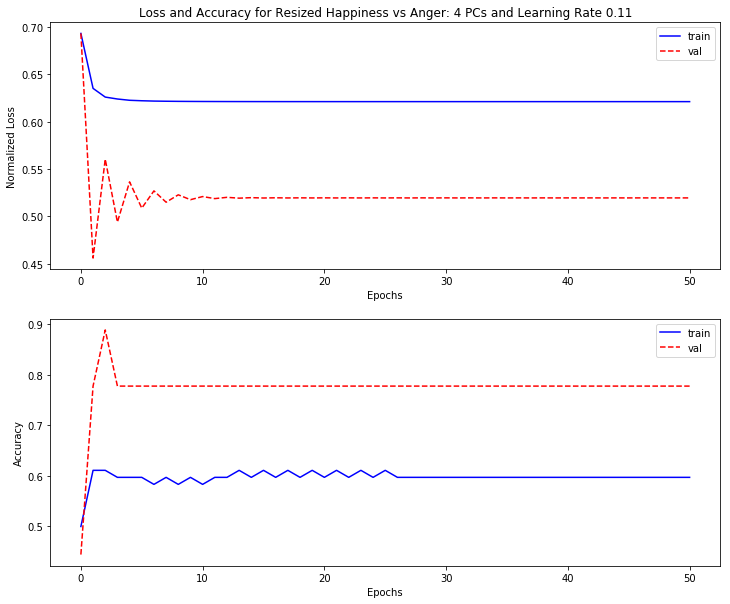

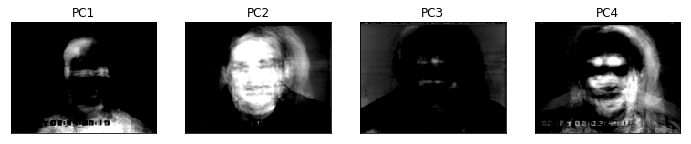

In [181]:
HappyVsAngry(4, 0.11, 10, 50)

Emotions: ['anger', 'happiness'] 

anger: 45 # of images
happiness: 69 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
0.8
0.1
0.1
EARLY STOPPING AT EPOCH: 1
The final train accuracy is: 0.5972222222222222
The minimum val loss is: 0.4892723123810737 ocurring after 37 epochs
The normalized TEST LOSS is: 0.9933885073753616
The accuracy on the TEST SET is: 0.6666666666666666


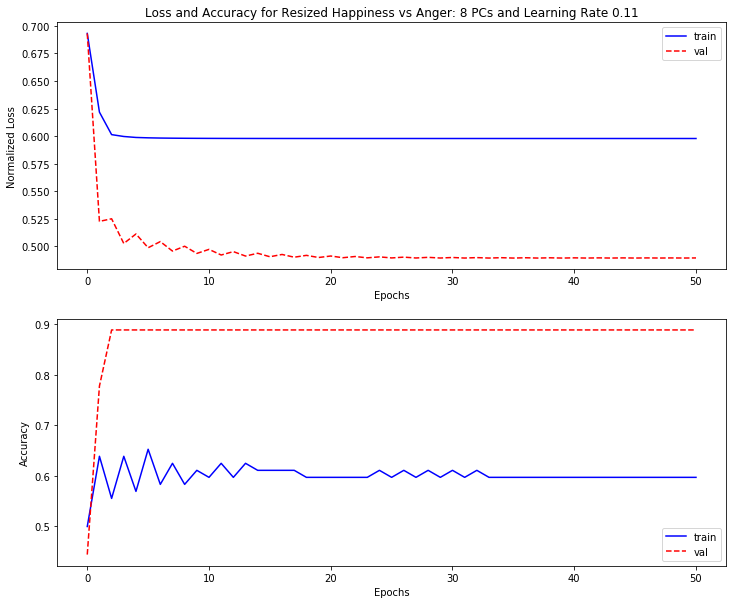

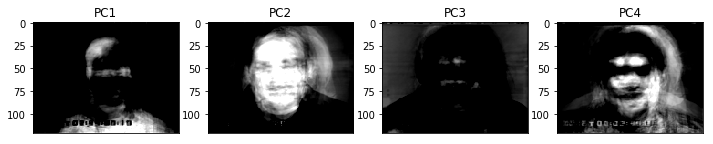

In [45]:
HappyVsAngry(8, 0.11, 10, 50)

Emotions: ['anger', 'happiness'] 

anger: 45 # of images
happiness: 69 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
0.8
0.1
0.1
EARLY STOPPING AT EPOCH: 1
The final train accuracy is: 0.6666666666666666
The minimum val loss is: 0.5084861400702927 ocurring after 49 epochs
The normalized TEST LOSS is: 1.0810822720896474
The accuracy on the TEST SET is: 0.6666666666666666


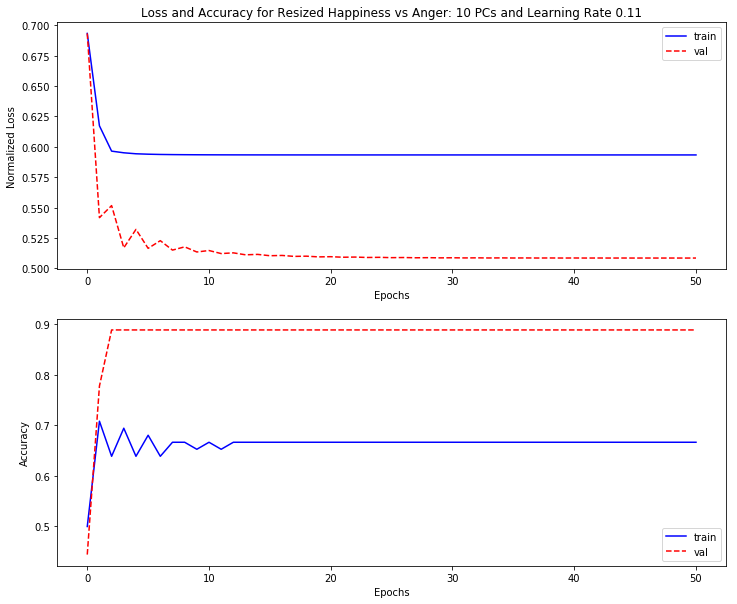

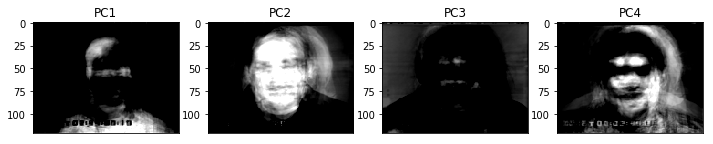

In [46]:
HappyVsAngry(10, 0.11, 10, 50)

In [318]:
#5c implementation
#INPUT: 1) Number of principal components (int) 2) Learning Rate (float) 3) The number of k components (int) 4) Number of Epochs (int) 5) emotion (str) 6) emotion (str)
#OUTPUT: Displays the TEST accuracy and loss as well as the VAL/Train normalized loss and accuracy plots as well as the first 4 PCs
#Note --> This function does not return anything
def LogRegAligned(howManyPrincipalComponents, alpha, k, numEpochs, firstEmotion, secondEmotion):
    forPartC = "./aligned/"
    dataset, cnt = load_data(forPartC)
    images = balanced_sampler(dataset, cnt, emotions=[firstEmotion, secondEmotion])
    #split into 10 folds
    splitEmUp, labels = CrossFold(images, k) 
    CheckMutuallyExclusive(splitEmUp)
    
    #implement cross validation:
    
    trainingLoss = []
    validationLoss = []
    testLoss = []

    trainPerformance = []
    valPerformance = []
    testPerformance = []
    
    
    for fold in range(k):
        #Since k is = 10 split into train,val,and test in 80/10/10 
        trainData = defaultdict(list)
        trainLabels = []
        valData = defaultdict(list)
        valLabels = []
        testData = defaultdict(list)
        testLabels = []
        counter = 0 
        
        valData["val"] = splitEmUp[fold]
        testData["test"] = splitEmUp[(fold + 1) %k]
        counter = 0
        for key,v in splitEmUp.items():
            if (counter != fold) and (counter != (fold +1) %k):
                for val in v: 
                    trainData["train"].append(val)
                for el in labels[key]:
                    trainLabels.append(el)
                counter += 1
            elif(counter == fold):
                for el in labels[key]:
                    valLabels.append(el)
                counter += 1 
            else:
                for el in labels[key]:
                    testLabels.append(el)
                counter += 1
        
        if len(testLabels) != len(valLabels):
            print("Strange things are happening")
            
        
        #Ensure fractions are correct!           
        #print(len(trainData["train"])/len([val for k,v in splitEmUp.items() for val in v]))
        #print(len(valData["val"])/len([val for k,v in splitEmUp.items() for val in v]))
        #print(len(testData["test"])/len([val for k,v in splitEmUp.items() for val in v]))
        
        #Perform PCA on train
        trainingMatrix = get_matrix(trainData)
        eig_vals, pcs = principal_components(trainingMatrix)
        mean_face = np.matrix.mean(trainingMatrix, axis = 1)
        
        #project all data onto top p (here howManyPrincipalComponents variable) train PC's scaled
        projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
        projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
        projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
        projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))
        
        #initialize weights 
        temporaryWeights = [0]*(1  + howManyPrincipalComponents)
        weights = np.array(temporaryWeights).reshape(len(temporaryWeights), 1) #column vector 
        
        # Establish baselines
        initialTrainPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5) for el in projectedTrain])
        initialValPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5) for el in projectedVal])
        
        trainLoss = [CrossEntropy(projectedTrain, trainLabels, weights)/len(projectedTrain)]
        valLoss = [CrossEntropy(projectedVal, valLabels, weights)/len(projectedVal)]
        trainAcc = [sum(initialTrainPredictions == np.array(trainLabels))/len(trainLabels)]
        valAcc = [sum(initialValPredictions == np.array(valLabels))/len(valLabels)]
        
        suchAWeightyConversation = weights.copy()
        earlyStop = False
        
        #Train the model
        for i in range(numEpochs):
            weights = weights + alpha*Gradient(projectedTrain, trainLabels, weights)
        
            #print("After one step the train loss is: " + str(CrossEntropy(projectedTrain, trainLabels, weights)))
            newTrainPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in projectedTrain])
            newValPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in projectedVal])
            #print("After one step the train accuracy is: " + str(sum(newPredictions == np.array(trainLabels))/len(trainLabels)))
        
            trainLoss.append(CrossEntropy(projectedTrain, trainLabels, weights)/len(projectedTrain))
            valLoss.append(CrossEntropy(projectedVal, valLabels, weights)/len(projectedVal))
            trainAcc.append(sum(newTrainPredictions == np.array(trainLabels))/len(trainLabels))
            valAcc.append(sum(newValPredictions == np.array(valLabels))/len(valLabels))
        
            #early stopping check
            if (valLoss[len(valLoss)-1] < valLoss[len(valLoss)-2]) and (not earlyStop):
                suchAWeightyConversation = weights.copy()
            else:
                earlyStop = True 
        
        #Record the results from this cross validation run:
        trainingLoss.append(trainLoss)
        trainPerformance.append(trainAcc)
        validationLoss.append(valLoss)
        valPerformance.append(valAcc)
        testLoss.append(CrossEntropy(projectedTest, testLabels, suchAWeightyConversation)/len(projectedTest))
        testPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, suchAWeightyConversation)) > 0.5)for el in projectedTest])
        testPerformance.append(sum(testPredictions == np.array(testLabels))/len(testLabels))
    
    #Report test performance statistics:   
    print("The average test loss is: " + str(sum(testLoss)/len(testLoss)) + " (" + str(np.std(testLoss)) + ")")
    print("The average test accuracy is: " + str(sum(testPerformance)*100/len(testPerformance)) + "% (" + str(np.std(testPerformance)*100) + ")")
    #print(testLoss)
    #print((testPerformance))
    #print(len(validationLoss[0]))
    
    #Create data structures for plotting: 
    trainLossForPlotting = list()
    valLossForPlotting = list()
    trainAccForPlotting = list()
    valAccForPlotting = list()
    for i in range(numEpochs+1):
        temp = list()
        for j in range(len(trainingLoss)):
            temp.append(trainingLoss[j][i])
        trainLossForPlotting.append([np.mean(temp), np.std(temp)])
    
    for i in range(numEpochs+1):
        temp = list()
        for j in range(len(validationLoss)):
            temp.append(validationLoss[j][i])
        valLossForPlotting.append([np.mean(temp), np.std(temp)])
    
    for i in range(numEpochs+1):
        temp = list()
        for j in range(len(trainPerformance)):
            temp.append(trainPerformance[j][i])
        trainAccForPlotting.append([np.mean(temp), np.std(temp)])
        
    for i in range(numEpochs+1):
        temp = list()
        for j in range(len(valPerformance)):
            temp.append(valPerformance[j][i])
        valAccForPlotting.append([np.mean(temp), np.std(temp)])
        
    #Create validation and train plots:
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)
    #yerr= [el[1]/2 for el in trainLossForPlotting]
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlotting],'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlotting[i][0] for i in range(10, len(trainLossForPlotting)) if i%10 == 0],yerr = [trainLossForPlotting[i][1]/2 for i in range(10, len(trainLossForPlotting)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valLossForPlotting], 'r--' , label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valLossForPlotting[i][0] for i in range(10, len(valLossForPlotting)) if i%10 == 0],yerr = [valLossForPlotting[i][1]/2 for i in range(10, len(valLossForPlotting)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    plt.title("Loss and Accuracy for Aligned " + secondEmotion + " vs " + firstEmotion + ": "+ str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha))
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainAccForPlotting], 'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainAccForPlotting[i][0] for i in range(10, len(trainAccForPlotting)) if i%10 == 0],yerr = [trainAccForPlotting[i][1]/2 for i in range(10, len(trainAccForPlotting)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valAccForPlotting], 'r--', label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valAccForPlotting[i][0] for i in range(10, len(valAccForPlotting)) if i%10 == 0],yerr = [valAccForPlotting[i][1]/2 for i in range(10, len(valAccForPlotting)) if i%10 == 0], fmt = "ro", alpha = 0.55)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Plot the first four principal components plotted as images:
    plt.figure(figsize=(12,12))
    for i in range(4):
        plt.subplot(1,6,i+1)
        plt.title("PC" + str(i+1))
        forPlotting = np.array(np.reshape(pcs[:,i], (images[firstEmotion][0].shape[0], images[firstEmotion][0].shape[1])))
        img = Image.fromarray(forPlotting)
        plt.imshow(img)
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    return trainLossForPlotting 


Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
The average test loss is: 0.17212038591968593 (0.19543480259432577)
The average test accuracy is: 95.55555555555557% (10.183501544346313)


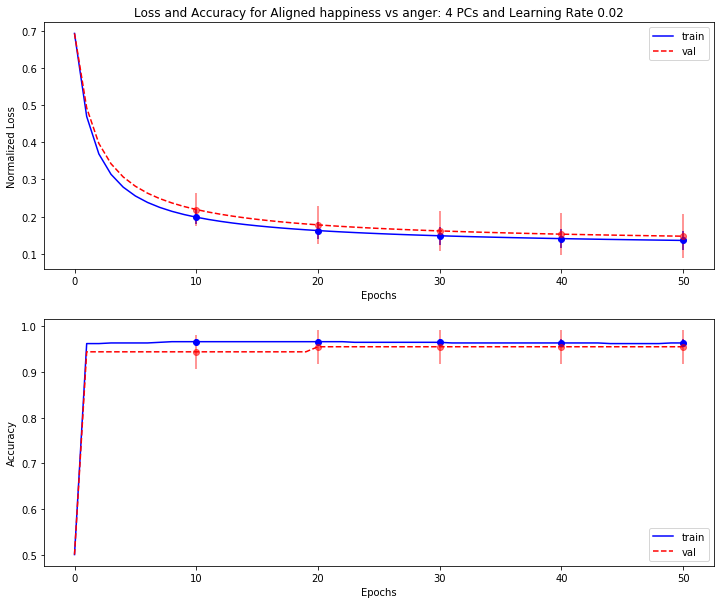

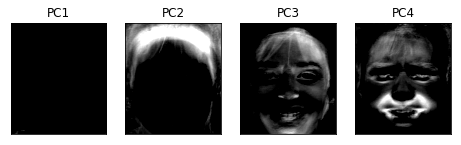

In [319]:
oneLearningRate = LogRegAligned(4, 0.02, 10, 50,'anger', 'happiness')

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
The average test loss is: 0.1983669840331696 (0.2777652309332918)
The average test accuracy is: 94.44444444444444% (11.385500851066222)


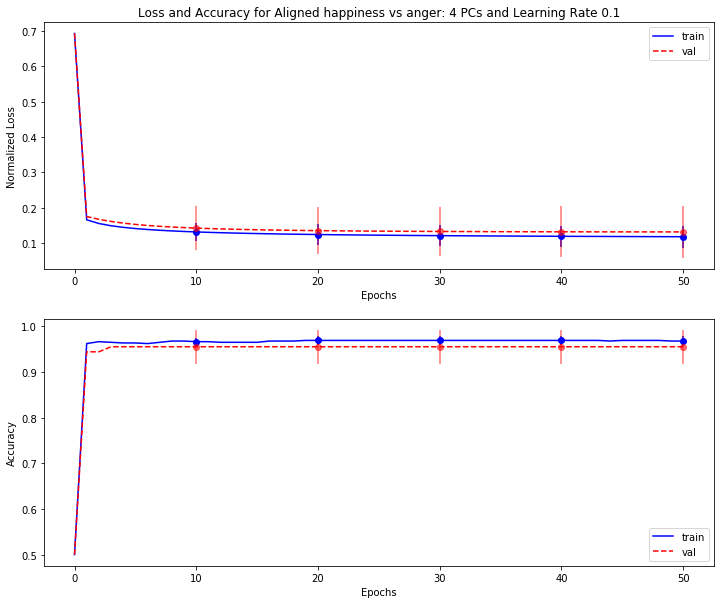

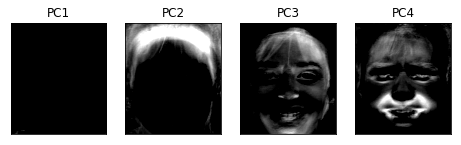

In [320]:
secondLearningRate = LogRegAligned(4, 0.1, 10, 50,'anger', 'happiness')

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
The average test loss is: 0.3119613377117644 (0.5926367947731006)
The average test accuracy is: 91.11111111111111% (13.877773329774218)


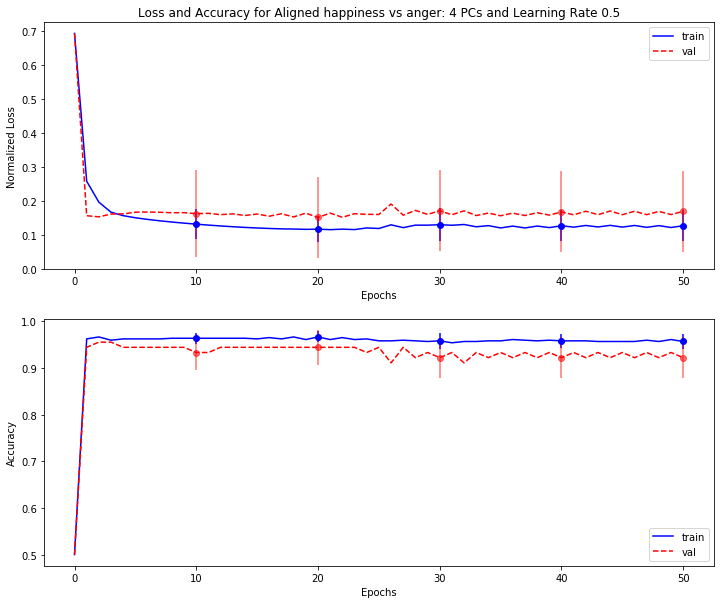

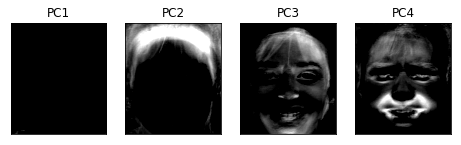

In [321]:
thirdLearningRate = LogRegAligned(4, .5, 10, 50,'anger', 'happiness')

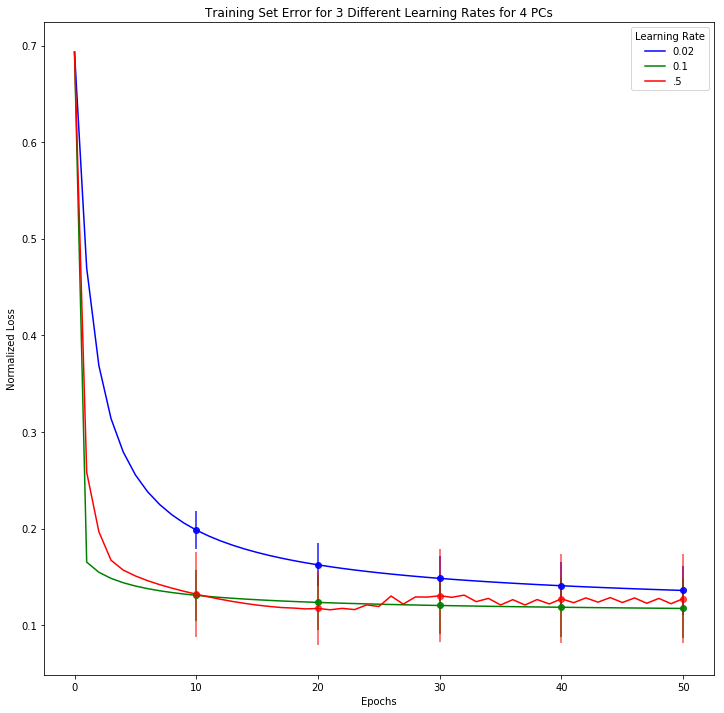

In [322]:
#5c (iii) --> plot of loss for 3 different learning rates for 4 PCs
plt.figure(figsize=(12,12))
plt.plot([i for i in range(len(oneLearningRate))], [el[0] for el in oneLearningRate], "b", label = "0.02")
plt.errorbar([i for i in range(10,60,10)], [oneLearningRate[i][0] for i in range(10, len(oneLearningRate)) if i%10==0], yerr = [oneLearningRate[i][1]/2 for i in range(10,len(oneLearningRate)) if i%10==0],fmt = "bo", alpha = 0.9)
plt.plot([i for i in range(len(secondLearningRate))], [el[0] for el in secondLearningRate], "g", label = "0.1")
plt.errorbar([i for i in range(10,60,10)], [secondLearningRate[i][0] for i in range(10, len(secondLearningRate)) if i%10==0], yerr = [secondLearningRate[i][1]/2 for i in range(10,len(secondLearningRate)) if i%10==0],fmt = "go", alpha = 0.9)
plt.plot([i for i in range(len(thirdLearningRate))], [el[0] for el in thirdLearningRate], "r", label = ".5")
plt.errorbar([i for i in range(10,60,10)], [thirdLearningRate[i][0] for i in range(10, len(thirdLearningRate)) if i%10==0], yerr = [thirdLearningRate[i][1]/2 for i in range(10,len(thirdLearningRate)) if i%10==0],fmt = "ro", alpha = 0.7)
plt.title("Training Set Error for 3 Different Learning Rates for 4 PCs")
plt.xlabel("Epochs")
plt.ylabel("Normalized Loss")
plt.legend(title = "Learning Rate")

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
The average test loss is: 0.10222001896730541 (0.1979241019393877)
The average test accuracy is: 98.88888888888889% (3.333333333333335)


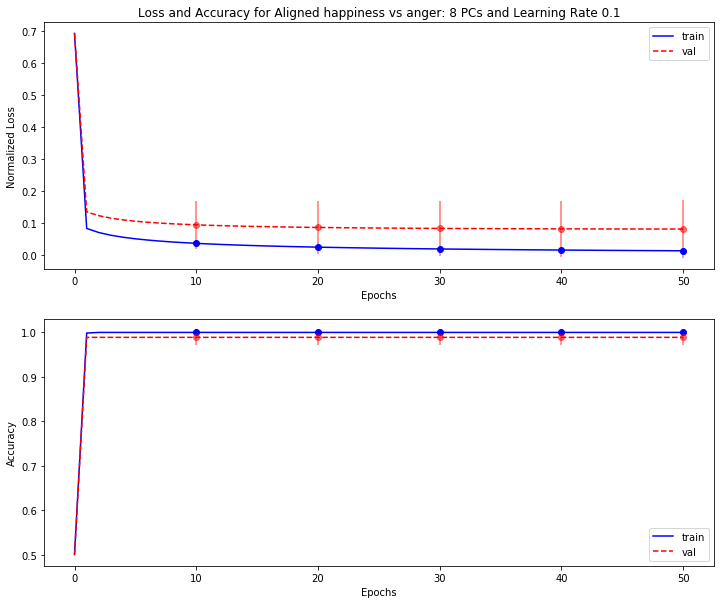

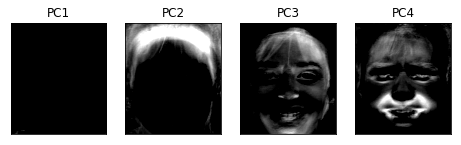

In [323]:
#Perform remainder of PC runs --> 8 and 10
wontBeUsed = LogRegAligned(8, .1, 10, 50,'anger', 'happiness')

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
anger: 45 # of images
happiness: 45 # of images
The average test loss is: 0.03971261255007194 (0.06219919321027652)
The average test accuracy is: 98.88888888888889% (3.333333333333335)


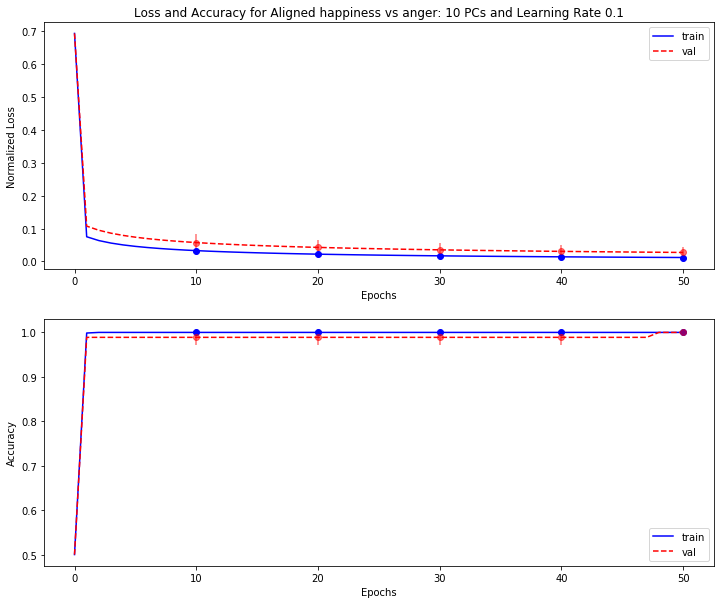

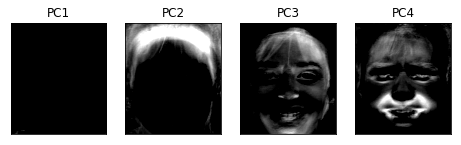

In [324]:
alsoWontBeUSed = LogRegAligned(10, .1, 10, 50,'anger', 'happiness')

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
surprise: 25 # of images
fear: 25 # of images
The average test loss is: 0.19262850057748504 (0.1947556385951385)
The average test accuracy is: 93.99999999999999% (9.165151389911678)


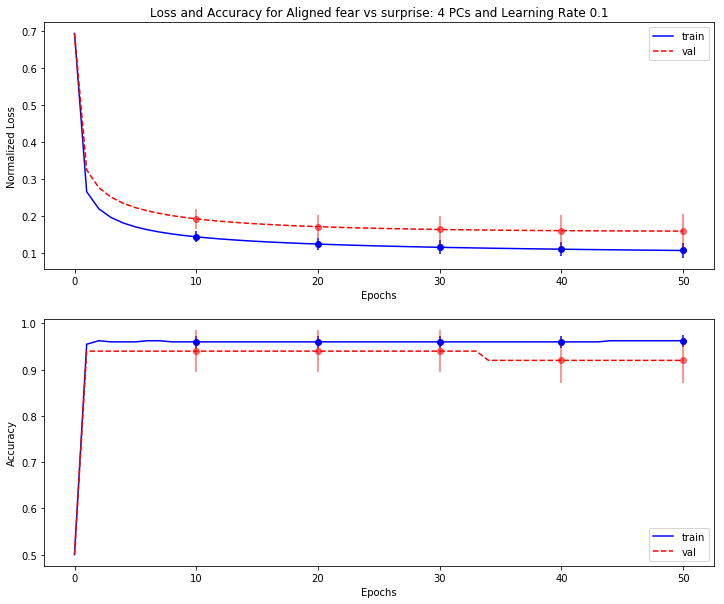

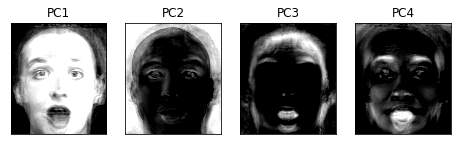

In [325]:
#Question 5d:
cuatro = LogRegAligned(4, .1, 10, 50, 'surprise', 'fear')

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
surprise: 25 # of images
fear: 25 # of images
The average test loss is: 0.1475048376746863 (0.09910651455004908)
The average test accuracy is: 91.99999999999999% (9.797958971132712)


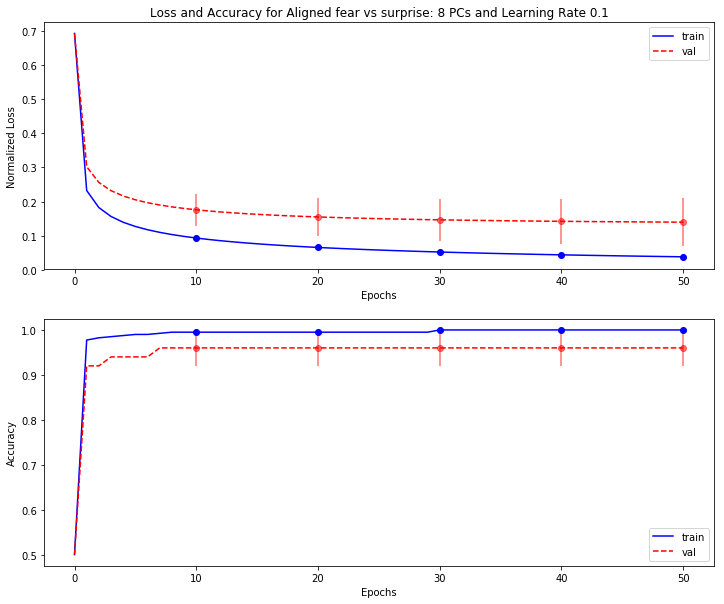

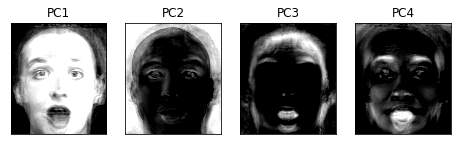

In [327]:
ocho = LogRegAligned(8, .1, 10, 50, 'surprise', 'fear')

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
surprise: 25 # of images
fear: 25 # of images
The average test loss is: 0.17703498849083293 (0.14760111214166877)
The average test accuracy is: 93.99999999999999% (9.165151389911678)


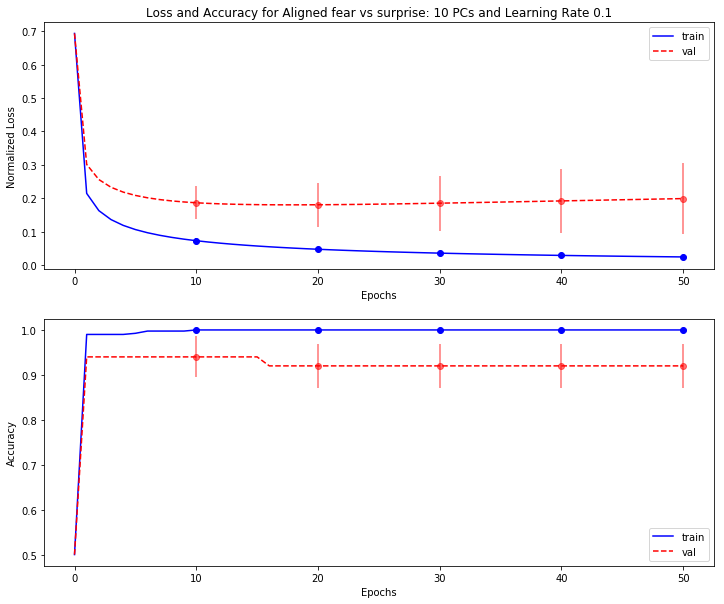

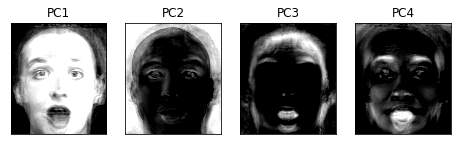

In [328]:
dies = LogRegAligned(10, .1, 10, 50, 'surprise', 'fear')

In [7]:
if __name__ == "__main__":
    # The relative path to your image directory
    data_dir = "./aligned/"
    dataset, cnt = load_data(data_dir)
    # test with happiness and anger
    images = balanced_sampler(dataset, cnt, emotions=['happiness', 'fear'])
    
    splitEmUp,labels = CrossFold(images, 10)
    
    print([len(v) for k,v in splitEmUp.items()])
    CheckMutuallyExclusive(splitEmUp)
    
    
    imagesChanged= get_matrix(images)
    eig_vals, pcs = principal_components(imagesChanged)
    mean_face = np.matrix.mean(imagesChanged, axis = 1)
    #display_face(np.array(np.reshape(mean_face, (n1,n2))))
    centered_matrix = imagesChanged - mean_face
    numPCs = 10
    projectedData = project_k_dimensions(mean_face, imagesChanged, eig_vals, pcs, numPCs).T #returns a Mxk matrix
    print("PROJECTED DATA: ")
    print(projectedData.shape)
    #print(projectedData[0]) # may need to look into the way labels are organized... 
    
    #IMPLEMENT the MatrixToListOfTransformedArrays funciton above ans set inListForm equal to this
    inListForm = Transform(MatrixToListOfTransformedArrays(projectedData))
    targetsInListForm = []
    whichClassAmI = 0
    for k,v in images.items():
        for vals in v:
            targetsInListForm.append(whichClassAmI)  
        whichClassAmI += 1
    
    
    #temporaryWeights = [0]*(1 + splitEmUp[0][0].shape[0]*splitEmUp[0][0].shape[1])
    temporaryWeights = [0]*(1  + numPCs)
    weights = np.array(temporaryWeights).reshape(len(temporaryWeights), 1) #column vector 
    
    initialPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in inListForm])
    print("The initial accuracy is: " + str(sum(initialPredictions == np.array(targetsInListForm))/len(targetsInListForm)))
    print("The loss is: " + str(CrossEntropy(inListForm, targetsInListForm, weights)))
    #print(initialPredictions)
    learningRate = 0.1
    for i in range(50):
        weights = weights + learningRate*Gradient(inListForm, targetsInListForm, weights)
        #print("After one step the loss is: " + str(CrossEntropy(inListForm, targetsInListForm, weights)))
        print("new loss is: " + str(CrossEntropy(inListForm, targetsInListForm, weights)))
    finalPredictions = np.array([(ComputeSigmoidFunction(np.dot(el, weights)) > 0.5)for el in inListForm])
    print("The final accuracy is: " + str(sum(finalPredictions == np.array(targetsInListForm))/len(targetsInListForm)))
    #display_index = 0

Emotions: ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'] 

anger: 45 # of images
disgust: 59 # of images
fear: 25 # of images
happiness: 69 # of images
sadness: 28 # of images
surprise: 83 # of images

Balanced Set:
happiness: 25 # of images
fear: 25 # of images
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
PROJECTED DATA: 
(50, 10)
The initial accuracy is: 0.5
The loss is: 34.65735902799723
new loss is: 9.747222855034282
new loss is: 7.98698238755938
new loss is: 6.960274501569327
new loss is: 6.254739123148532
new loss is: 5.726631751807972
new loss is: 5.309705063745756
new loss is: 4.968308805431625
new loss is: 4.681218079147762
new loss is: 4.434855423356484
new loss is: 4.22005347059858
new loss is: 4.03035521426327
new loss is: 3.861054896480642
new loss is: 3.70862512281385
new loss is: 3.5703584946029774
new loss is: 3.444134665560924
new loss is: 3.328263931503464
new loss is: 3.2213792397399965
new loss is: 3.122359798579673
new loss is: 3.0302758753355956
new loss is: 2